In [39]:
#install Packages if needed(uncomment them run them, if needed)
#!pip install findspark
#!pip install pyspark

#!pip install jupyter
#!pip install pip
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#!pip install matplotlib-inline
#!pip install seaborn

In [40]:
#importing all the packages and libraries i will need to make the code work
from pyspark.sql.types import StructType,StructField,StringType,IntegerType
from pyspark.sql.functions import col
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# schema for use with our own created dataframes later.. we could have loaded it from a CSV?
#schema = StructType([StructField("column1Name",StringType(),True),StructField("column2Name", IntegerType(), True)])

In [41]:
#To import, enable, initalise spark into jupyter
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.sql("select 'Spark' as Hello")
#df = spark.sql("select 'spark', 'myron' as hello")
#print('\n\n')
df.show()

+-----+
|Hello|
+-----+
|Spark|
+-----+



In [42]:
#task 1

#loading the .csv file into a dataframe
df = spark.read.csv("week4.csv", inferSchema= True, header=True)

#printing the loaded dataset(df is the name of the dataframe)
df.show()
#df.printSchema()

+-----------+---------+------------+
|       name|happiness|happiness-id|
+-----------+---------+------------+
|    Gabriel|      sad|           0|
|    Freddie|    happy|           1|
|      Louis|      sad|           0|
|      Aaron|    happy|           1|
|     Piyush|      sad|           0|
|      Myron|    happy|           1|
|Maximillion|    happy|           1|
|     Naruto|      sad|           0|
|      Eeren|    happy|           1|
|      Annie|    happy|           1|
|       Kell|    mello|           2|
|     snappi|    mello|           2|
+-----------+---------+------------+



In [43]:
#importing the StringIndexer class from pyspark
from pyspark.ml.feature import StringIndexer

#importing the stringindexer estimator(attempt 1)
indexer = StringIndexer(inputCol="happiness", outputCol="happinessIndexer", stringOrderType="frequencyAsc")
indexed = indexer.fit(df).transform(df)
indexed.select("happiness","happinessIndexer").show()
#indexed.show()

#StringIndexer assigns an unique index to ever unique vale of the inputcolum
#https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StringIndexer.html#pyspark.ml.feature.StringIndexer.setStringOrderType

+---------+----------------+
|happiness|happinessIndexer|
+---------+----------------+
|      sad|             1.0|
|    happy|             2.0|
|      sad|             1.0|
|    happy|             2.0|
|      sad|             1.0|
|    happy|             2.0|
|    happy|             2.0|
|      sad|             1.0|
|    happy|             2.0|
|    happy|             2.0|
|    mello|             0.0|
|    mello|             0.0|
+---------+----------------+



In [44]:
#learning Transformers and Estimators
#load Movie review dataset and clean the data

df1 = spark.read.csv("MovieReviewsKaggle_Clean.csv",inferSchema=True, header=True)

#shows the dataframe
df1.show(truncate=50)

#show teh schema of the dataframe
#df1.printSchema()



+--------------------------------------------------+-----+
|                                              text|label|
+--------------------------------------------------+-----+
|I grew up (b. 1965) watching and loving the Thu...|    0|
|When I put this movie in my DVD player, and sat...|    0|
|Why do people who do not know what a particular...|    0|
|Even though I have great interest in Biblical m...|    0|
|Im a die hard Dads Army fan and nothing will ev...|    1|
|A terrible movie as everyone has said. What mad...|    0|
|Finally watched this shocking movie last night,...|    1|
|I caught this film on AZN on cable. It sounded ...|    0|
|It may be the remake of 1987 Autumn's Tale afte...|    1|
|My Super Ex Girlfriend turned out to be a pleas...|    1|
|I can't believe people are looking for a plot i...|    1|
|If you haven't seen the gong show TV series the...|    0|
|I have always been a huge fan of "Homicide: Lif...|    1|
|Greg Davis and Bryan Daly take some crazed stat...|    

In [45]:
#get the distinct number of rows in the dataframe
print(df1.distinct().count())

#gets the number of rows in specified colums individually
print(df1.select('text').count())
print(df1.select('label').count())

#print the value fom reow 1 of the colum text
#df1.select('text').show()

39723
40000
40000


In [46]:
#counting the number of null and NaN fileds(null and Nan values only)

from pyspark.sql.functions import col, isnan, when, count

df1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df1.columns]).show()

+----+-----+
|text|label|
+----+-----+
|   0|    0|
+----+-----+



In [47]:
# Find count for empty, None, Null, Nan with string literals.
import numpy as np
from pyspark.sql.functions import col, isnan, when, count

df2 = df1.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df1.columns])
df2.show()

+----+-----+
|text|label|
+----+-----+
| 402|    0|
+----+-----+



In [48]:
#to show rows with null values. [df.filter(df.colName.isNull()).show()]
df1.filter(df1.text.isNull()).show()

#https://sparkbyexamples.com/pyspark/pyspark-filter-rows-with-null-values/

+----+-----+
|text|label|
+----+-----+
+----+-----+



In [49]:
#drop rows with null values using df.dropna()

rowCountBefore = df1.count()
#make new dataFrame to store the new dataframe without the removed rows
df3 = df1.dropna()
rowCountAfter = df3.count()

print("rows difference after dropping the null values {} \n".format(rowCountBefore-rowCountAfter))
df3.count()

#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html

rows difference after dropping the null values 0 



40000

In [50]:
#Removing rows with Duplicate values
rowCountBefore = df1.count()
#make new dataFrame to store the new dataframe without the removed rows
df4 = df1.dropDuplicates(subset=['text']) #subset specifies which colum to use for checking duplicates
rowCountAfter = df4.count()

print("rows difference after dropping the null values {} \n".format(rowCountBefore-rowCountAfter))
df4.count()

rows difference after dropping the null values 277 



39723

In [51]:
#Practicing TRANSFORMERS AND ESTIMATORS

#1) TRASFORMERS-TOKENIZER

df5 = spark.read.csv("tokenizer.csv",inferSchema=True, header=True)
df5.show()

+--------------------+
|                text|
+--------------------+
|my name is myron ...|
|my name is michal...|
|this is a test do...|
+--------------------+



In [52]:
#Tokenizer takes an input sentence as a single string, turns it into lowercase and splits it into individual words by splitting at whitespace

from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType

tokenizer = Tokenizer(inputCol="text", outputCol="words")

regexTokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")
# alternatively, pattern="\\w+", gaps(False)

countTokens = udf(lambda words: len(words), IntegerType())

#tokenized is a dataframe now
tokenized = tokenizer.transform(df5)
print("Tokenizer")
tokenized.select("text", "words")\
    .withColumn("tokens", countTokens(col("words"))).show(truncate=False)

#regexTokenized is a dataframe now
regexTokenized = regexTokenizer.transform(df5)
print("RegexTokenizer")
regexTokenized.select("text", "words")\
    .withColumn("tokens", countTokens(col("words"))).show(truncate=False)\
    

#https://spark.apache.org/docs/latest/ml-features#tokenizer

Tokenizer
+-----------------------------------------+-----------------------------------------------------+------+
|text                                     |words                                                |tokens|
+-----------------------------------------+-----------------------------------------------------+------+
|my name is myron and I live in southall  |[my, name, is, myron, and, i, live, in, southall]    |9     |
|my name is michal and I like to wal a lot|[my, name, is, michal, and, i, like, to, wal, a, lot]|11    |
|this is a test do do not repeat after me |[this, is, a, test, do, do, not, repeat, after, me]  |10    |
+-----------------------------------------+-----------------------------------------------------+------+

RegexTokenizer
+-----------------------------------------+-----------------------------------------------------+------+
|text                                     |words                                                |tokens|
+----------------------------

In [53]:
#silde 31
#StopWordsRemover are words which should be excluded from the input, typically because the words appear frequently and don’t carry as much meaning.
from pyspark.ml.feature import StopWordsRemover
#the inputColum needs to be the output colum from tokenizer(i.e. words from the df tokenized)
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
remover.transform(tokenized).show(truncate=False)
#above use the array tokenized from the tokenizer transform not df from the read.csv file

+-----------------------------------------+-----------------------------------------------------+------------------------------+
|text                                     |words                                                |filtered                      |
+-----------------------------------------+-----------------------------------------------------+------------------------------+
|my name is myron and I live in southall  |[my, name, is, myron, and, i, live, in, southall]    |[name, myron, live, southall] |
|my name is michal and I like to wal a lot|[my, name, is, michal, and, i, like, to, wal, a, lot]|[name, michal, like, wal, lot]|
|this is a test do do not repeat after me |[this, is, a, test, do, do, not, repeat, after, me]  |[test, repeat]                |
+-----------------------------------------+-----------------------------------------------------+------------------------------+



In [54]:
#2) TRASFORMERS-N_GRAM
from pyspark.ml.feature import NGram
#first create an array n_remover from the StopWordsRemover function above
n_remover = remover.transform(tokenized)
#ngram function code
ngram = NGram(n=2, inputCol="filtered", outputCol="ngrams")

ngramDataFrame = ngram.transform(n_remover)
ngramDataFrame.select("ngrams").show(truncate=False)

#https://spark.apache.org/docs/2.2.0/ml-features.html#tokenizer

+---------------------------------------------+
|ngrams                                       |
+---------------------------------------------+
|[name myron, myron live, live southall]      |
|[name michal, michal like, like wal, wal lot]|
|[test repeat]                                |
+---------------------------------------------+



In [55]:
#3) TRASFORMERS-OneHotEncoder
from pyspark.ml.feature import OneHotEncoder

df = spark.createDataFrame([
    (0.0, 1.0),
    (1.0, 0.0),
    (2.0, 1.0),
    (0.0, 2.0),
    (0.0, 1.0),
    (2.0, 0.0)
], ["categoryIndex1", "categoryIndex2"])

encoder = OneHotEncoder(inputCols=["categoryIndex1", "categoryIndex2"],
                        outputCols=["categoryVec1", "categoryVec2"])
model = encoder.fit(df)
encoded = model.transform(df)
encoded.show()

+--------------+--------------+-------------+-------------+
|categoryIndex1|categoryIndex2| categoryVec1| categoryVec2|
+--------------+--------------+-------------+-------------+
|           0.0|           1.0|(2,[0],[1.0])|(2,[1],[1.0])|
|           1.0|           0.0|(2,[1],[1.0])|(2,[0],[1.0])|
|           2.0|           1.0|    (2,[],[])|(2,[1],[1.0])|
|           0.0|           2.0|(2,[0],[1.0])|    (2,[],[])|
|           0.0|           1.0|(2,[0],[1.0])|(2,[1],[1.0])|
|           2.0|           0.0|    (2,[],[])|(2,[0],[1.0])|
+--------------+--------------+-------------+-------------+



In [56]:
#4) TRASFORMERS-NORMALIZER
from pyspark.ml.feature import Normalizer
from pyspark.ml.linalg import Vectors

dataFrame = spark.createDataFrame([
    (0, Vectors.dense([1.0, 0.5, -1.0]),),
    (1, Vectors.dense([2.0, 1.0, 1.0]),),
    (2, Vectors.dense([4.0, 10.0, 2.0]),)
], ["id", "features"])

# Normalize each Vector using $L^1$ norm.
normalizer = Normalizer(inputCol="features", outputCol="normFeatures", p=1.0)
l1NormData = normalizer.transform(dataFrame)
print("Normalized using L^1 norm")
l1NormData.show()

# Normalize each Vector using $L^\infty$ norm.
lInfNormData = normalizer.transform(dataFrame, {normalizer.p: float("inf")})
print("Normalized using L^inf norm")
lInfNormData.show()


#https://spark.apache.org/docs/latest/ml-features.html#normalizer

Normalized using L^1 norm
+---+--------------+------------------+
| id|      features|      normFeatures|
+---+--------------+------------------+
|  0|[1.0,0.5,-1.0]|    [0.4,0.2,-0.4]|
|  1| [2.0,1.0,1.0]|   [0.5,0.25,0.25]|
|  2|[4.0,10.0,2.0]|[0.25,0.625,0.125]|
+---+--------------+------------------+

Normalized using L^inf norm
+---+--------------+--------------+
| id|      features|  normFeatures|
+---+--------------+--------------+
|  0|[1.0,0.5,-1.0]|[1.0,0.5,-1.0]|
|  1| [2.0,1.0,1.0]| [1.0,0.5,0.5]|
|  2|[4.0,10.0,2.0]| [0.4,1.0,0.2]|
+---+--------------+--------------+



In [57]:
#4) TRASFORMERS-VECTOR ASSEMBLER
#VectorAssembler combines different vector features and combines them into a single vector value
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

dataset = spark.createDataFrame(
    [(0, 18, 1.0, Vectors.dense([0.0, 10.0, 0.5]), 1.0)],
    ["id", "hour", "mobile", "userFeatures", "clicked"])
dataset.show()

assembler = VectorAssembler(
    inputCols=["hour", "mobile", "userFeatures"],
    outputCol="features")

output = assembler.transform(dataset)
print("Assembled columns 'hour', 'mobile', 'userFeatures' to vector column 'features'")
output.select("features", "clicked").show(truncate=False)


#https://spark.apache.org/docs/latest/ml-features.html#vectorassembler

+---+----+------+--------------+-------+
| id|hour|mobile|  userFeatures|clicked|
+---+----+------+--------------+-------+
|  0|  18|   1.0|[0.0,10.0,0.5]|    1.0|
+---+----+------+--------------+-------+

Assembled columns 'hour', 'mobile', 'userFeatures' to vector column 'features'
+-----------------------+-------+
|features               |clicked|
+-----------------------+-------+
|[18.0,1.0,0.0,10.0,0.5]|1.0    |
+-----------------------+-------+



In [58]:
#basically transformers call .transform() and
#take input and output columns, where as estimators have a .fit() function that must
#be called to train a model, which you can then call .transform() on

In [59]:
#TASK 2 SENTIMENT ANALYSIS (page 38)
##----------------------------------------------------------------------------##
##----------------------------------------------------------------------------##
##----------------------------------------------------------------------------##
##----------------------------------------------------------------------------##

In [60]:
#1) import the kaggle dataset needed

df = spark.read.csv("MovieReviewsKaggle_Clean.csv", inferSchema=True, header=True)
#n=number of rows to display, truncate= no of characters displayed from each row
#df.show(n=10, truncate=100)
#df.show()
#df.printSchema()

In [61]:
#2) importing all the packages and libraries i will need to make the code work
from pyspark.sql.types import StructType,StructField,StringType,IntegerType
from pyspark.sql.functions import col
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as plt
# schema for use with our own created dataframes later.. we could have loaded it from a CSV?
#schema = StructType([StructField("text",StringType(),True),StructField("label", IntegerType(), True)])

In [62]:
#since ML models do not accept string the data has to by supplied as Vectors

#3) split the dataframe into train and test dataframes
train, test = df.randomSplit([0.7,0.3])
#train, test = df.randomSplit(weights=[0.7,0.3], seed= 13)

print(train.count())
print(test.count())
#train.show()

28056
11944


In [63]:
#import transformers from Spark.ML library
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover
from pyspark.ml import Pipeline
#import estimators from Spark.ML library
from pyspark.ml.classification import LogisticRegression

In [64]:
#Pipeline-transfoemer-1 --Tokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType

tokenizer = Tokenizer(inputCol="text", outputCol="words")

countTokens = udf(lambda words: len(words), IntegerType())
#remember only train data is to be used on transforms and classifiers, after split had been done
tokenized = tokenizer.transform(train)
tokenized.select("text", "words")\
    .withColumn("tokens", countTokens(col("words"))).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [65]:
#Pipeline-transfoemer-2 --stopWordRemover
#running the output of tokenizer thru StopWordRemover(2 methods)

#from spark documentation
#stopwordremover = StopWordsRemover(inputCol="words", outputCol="useful_words")
#stopWordDF = stopwordremover.transform(tokenized).show(truncate=False)

#or 
#from workshop(preffered)
stopwordremover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="useful_words")
stopwordremover.transform(tokenized).show(truncate=False)
#stopWordDF is the dataframe that can store the transformed data

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [66]:
#Pipeline-transfoemer-3 --HashingTF(slide 59)

from pyspark.ml.feature import HashingTF
#using Hashing TF on the tokenized data to get the term/word frequency
#use outputColum from stopWordsRemover as input here
#---------------------------------------------------------------------------------------------

#method 
hashTF = HashingTF(inputCol=stopwordremover.getOutputCol(),outputCol='features')
hashTF
#we get as output feature vector to be used to be used as train data

#NEXT WE PASS THE DATA TO AN ESTIMATOR

#https://spark.apache.org/docs/latest/api/scala/org/apache/spark/ml/feature/HashingTF.html
#example here: https://stackoverflow.com/questions/35205865/what-is-the-difference-between-hashingtf-and-countvectorizer-in-spark

HashingTF_d5344652a724

In [67]:
#Pipeline-Estimator-1 --LogisticRegression (slide 65)
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression

#input coulum here should be the output colum from the last transformer(i.e. HashingTF)
#below features is the input column,label holds our labels to be used for learning
lr = LogisticRegression(labelCol='label',featuresCol='features',maxIter=100,regParam=0.01)

#declare stages variable
stages = [tokenizer, stopwordremover, hashTF, lr]

#instantiate the pipeline by passing stages variable to it
pipeline = Pipeline(stages=stages)

#Fit the model on the training set by calline the train dataframe
pipemodel = pipeline.fit(train)

#https://spark.apache.org/docs/latest/ml-pipeline.html#example-pipeline

In [68]:
#run the trained PipelineModel on the test set
justpredicted = pipemodel.transform(test)
justpredicted.show()
#above is the outputted prediction dataframe

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|                text|label|               words|        useful_words|            features|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|"A total waste of...|    0|["a, total, waste...|["a, total, waste...|(262144,[2410,270...|[3.04794264350017...|[0.95469362141311...|       0.0|
|"ASTONISHING" Scr...|    0|["astonishing", s...|["astonishing", s...|(262144,[2701,340...|[4.63462103345711...|[0.99038358728455...|       0.0|
|"Broadcast News" ...|    1|["broadcast, news...|["broadcast, news...|(262144,[2787,542...|[-1.0450282832208...|[0.26018094914607...|       1.0|
|"Cinderella" is a...|    1|["cinderella", is...|["cinderella", fi...|(262144,[2548,332...|[-5.0853227833793...|[0.00614884750125.

In [69]:
#drop the useless columns from the nprediction dataframe
justpredicted = justpredicted.drop('words','useful_words','features','rawPrediction','probability')

justpredicted.show()
justpredicted.printSchema()
#mpte here the prediction column shoud be interger type, but is double. it is fixed below

+--------------------+-----+----------+
|                text|label|prediction|
+--------------------+-----+----------+
|"A total waste of...|    0|       0.0|
|"ASTONISHING" Scr...|    0|       0.0|
|"Broadcast News" ...|    1|       1.0|
|"Cinderella" is a...|    1|       1.0|
|"Embarassing" is ...|    0|       0.0|
|"Fly Me To The Mo...|    0|       0.0|
|"Go Fish" garnere...|    0|       0.0|
|"I'll Take You Th...|    1|       1.0|
|"Ice Age" is one ...|    1|       1.0|
|"If I wanted to d...|    1|       1.0|
|"Inuyasha " was a...|    0|       0.0|
|"It all depends o...|    1|       1.0|
|"L'Auberge Espagn...|    1|       1.0|
|"Miss Cast Away" ...|    1|       0.0|
|"Nobi" or "Fires ...|    1|       1.0|
|"Pixote: A Lei do...|    1|       1.0|
|"Power Play" star...|    0|       0.0|
|"Side Show" is on...|    1|       1.0|
|"Tart" is a pathe...|    0|       0.0|
|"The Cat's Meow" ...|    0|       1.0|
+--------------------+-----+----------+
only showing top 20 rows

root
 |-- text

In [70]:
#make dataframe a bit cleaner, making prediction colum integer from double
from pyspark.sql.types import IntegerType

predicted = justpredicted.withColumn("prediction",justpredicted["prediction"].cast(IntegerType()))
predicted.printSchema()
#predicted.show()

root
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- prediction: integer (nullable = true)



In [71]:
# print out a sample of the predicted labels and the real ones for some text

predicted.select(predicted.text,predicted.prediction,predicted.label).sample(0.01).show(n=20,truncate=80)

+--------------------------------------------------------------------------------+----------+-----+
|                                                                            text|prediction|label|
+--------------------------------------------------------------------------------+----------+-----+
|Cinema's greatest period started in post-War Europe with Italy's Neo-Realist ...|         1|    1|
|Conquerer of Shamballa shows what happens when creators of an Anime fail to u...|         0|    0|
|Deep SH.. is more like it! The eels are just cartooned in over the film. Thin...|         0|    0|
|Director F.W. Murnau wisely stuck with the silent film medium he knew so well...|         1|    0|
|I grew up watching, and loving this cartoon every year. I didn't think they w...|         1|    1|
|I had a vague idea of who Bettie Page was, partly due to her appearance in th...|         1|    1|
|People don't seem to agree with me that movies can be bad and good at the sam...|         0|    0|


In [72]:
#calculating accuracy (slide 75)
accuracy = predicted.filter(predicted.label == predicted.prediction).count() / float(test.count())
accuracy

0.8586738111185532

In [73]:
#calculating the confusion matrix (slide 77)
# total rows in test dataset
totaltestrows = predicted.count()
print(totaltestrows)

# count how many rows have correct positive predictions
positivecorrect = predicted.where((col("prediction")=="1") & (col("label")==1)).count()
print("positivecorrect: " + str(positivecorrect))

# count how many rows have correct negative predictions
negativecorrect = predicted.where((col("prediction")=="0") & (col("label")==0)).count()
print("negative correct: " + str(negativecorrect))

# count how many rows have incorrect positive predictions
positiveincorrect = predicted.where((col("prediction")=="1") & (col("label")==0)).count()
print("positive incorrect: " + str(positiveincorrect))

# count how many rows have incorrect negative predictions
negativeincorrect = predicted.where((col("prediction")=="0") & (col("label")==1)).count()
print("negative incorrect: " + str(negativeincorrect))

11944
positivecorrect: 5221
negative correct: 5035
positive incorrect: 935
negative incorrect: 753


10256
0.8586738111185532
[[5035  935]
 [ 753 5221]]


<AxesSubplot:>

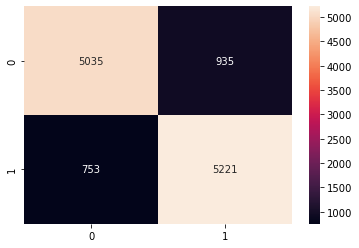

In [74]:
#plotting the confusion matrix (heatmap)(slide 83)

totalcorrect = positivecorrect + negativecorrect
print(totalcorrect)
print(totalcorrect/totaltestrows)
labels = ['True Neg','False Pos','False Neg','True Pos']
values = [negativecorrect,positiveincorrect,negativeincorrect,positivecorrect]
labels = np.asarray(labels).reshape(2,2)
values = np.asarray(values).reshape(2,2)
confusion = ([[negativecorrect,positiveincorrect],[negativeincorrect,positivecorrect]])
print(values)
sns.heatmap(confusion,annot=True,fmt='g')


In [75]:


#data = [("I hardly could have given a poorer performance. I'd say it was shockingly bad",0)]
#schema = ["Text", "Number"]
#ndf = spark.createDataFrame(data=data, schema=schema)
#ndf.show()

In [79]:
#Running the valudation test (thisis running the trained model unseen data)

data = [("I hardly could have given a poorer performance. I'd say it was shockingly bad",0)]
schema = ["Text", "Number"]
ndf = spark.createDataFrame(data=data, schema=schema)
pred = pipemodel.transform(ndf)
pred.show(truncate=10)
data = [("I think this movie rocks, its almost perfect in its achievement its the best movie ever!",1)]
schema = ["Text", "Number"]
ndf = spark.createDataFrame(data=data, schema=schema)
pred = pipemodel.transform(ndf)
pred.show(truncate=10)

IllegalArgumentException: text does not exist. Available: Text, Number

In [ ]:
#adding the idf estimator after the HashingTF transformer can improve the accuracy of the model


AttributeError: 'SparkSession' object has no attribute 'textFile'